# Advanced Lane Lines Detection Pipeline

## Importing Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2

%matplotlib inline

# Make the plotImages function available
%run PlottingHelperFunctions.ipynb

## Calibrating the Camera

In [2]:
# globals used internally by the calibrateCamera function
gCamCalMatrix = None
gCamCalDistortionCoeff = None 

def calibrateCamera(debug=False):
    # return if the global camCalMatrix already exists
    global gCamCalMatrix
    global gCamCalDistortionCoeff
    
    if(gCamCalMatrix is not None):
        return gCamCalMatrix, gCamCalDistortionCoeff
    
    # keep track of one of the grayscaled calibration images
    grayImage = None
    
    # keep track of images
    images = []
    
    # create object points and image points arrays for all images
    objectPoints = [] # 3D Points to hold position in real world space
    imagePoints  = [] # 2D Points to hold position in the image plane
    
    # prepare object points
    objectPoint = np.zeros((9*6, 3), np.float32)
    objectPoint[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2) # reshape to X, Y coordinates
    
    # use calibration images
    for fileName in glob.glob("camera_cal/*.jpg"):
        # read in image
        image = mpimg.imread(fileName)
        # convert to gray scale
        grayImage = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) 
        # find chessboard corners for a 9x6 board
        ret, corners = cv2.findChessboardCorners(grayImage, (9,6), None)
    
        # append object and image points if corners found
        if ret:
            objectPoints.append(objectPoint)
            imagePoints.append(corners)
            
            # if debug enabled, show visualization of chessboard corners
            if debug:
                images.append(cv2.drawChessboardCorners(image, (9, 6), corners, ret))
    
    if grayImage is not None:
        ret, gCamCalMatrix, gCamCalDistortionCoeff, rVecs, tVecs = cv2.calibrateCamera(objectPoints, 
                                                                                       imagePoints, 
                                                                                       grayImage.shape[::-1], 
                                                                                       None, None)
    # if debug enabled, show visualization of undistorted images
    if debug:
        pass
        ## uncomment if debugging this section
        #for image in images:
        #    undistortedImage = cv2.undistort(image, gCamCalMatrix, gCamCalDistortionCoeff, None, gCamCalMatrix)
        #    
        #    plotImages([image, undistortedImage], 2)
    
    return gCamCalMatrix, gCamCalDistortionCoeff

## Correcting Image Distortion

In [35]:
def distortionCorrection(img, mtx, dist):
    # use the camera calibration matrix and distortion coefficients to 
    # undistort an image
    correctedImage = cv2.undistort(img, mtx, dist, None, mtx)
    return correctedImage

## Accentuating Lane Lines

Testing Color Transforms...


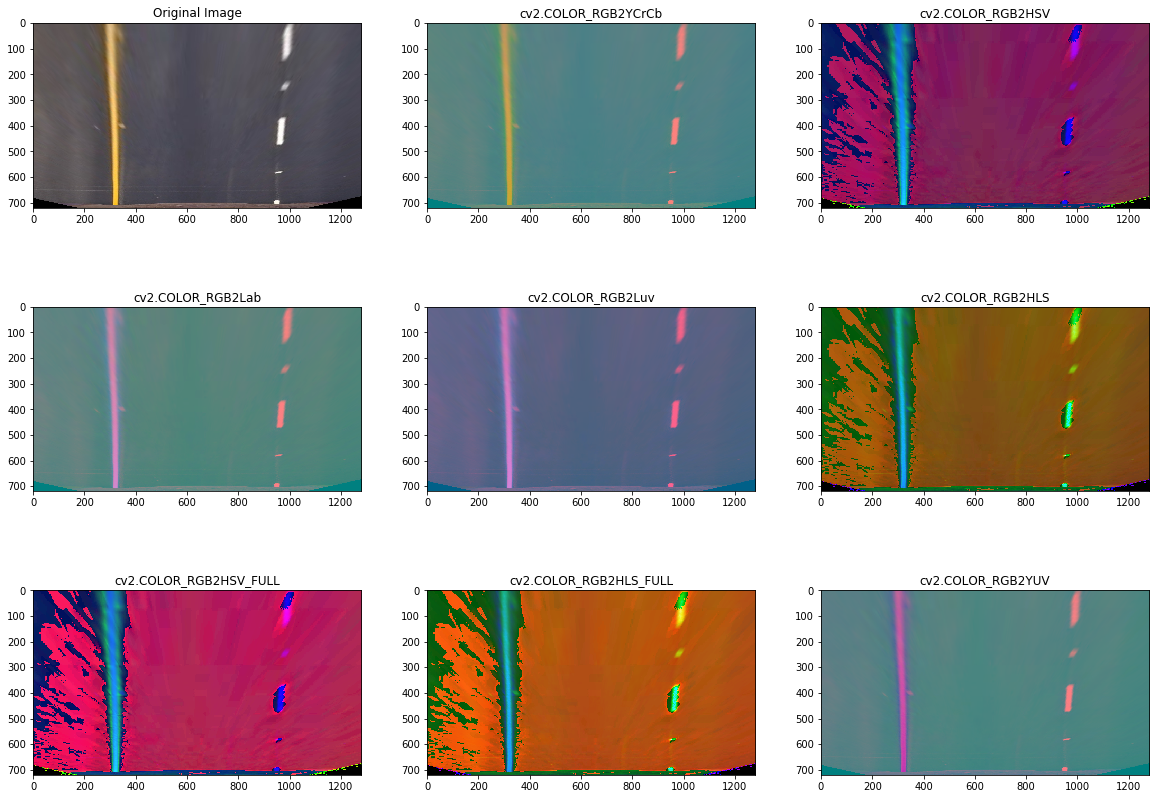

Testing Sobel X Gradient Thresholds...
Testing Gradient Thresh:  (25, 170)
Testing Gradient Thresh:  (15, 170)
Testing Gradient Thresh:  (10, 170)
Testing Gradient Thresh:  (5, 170)


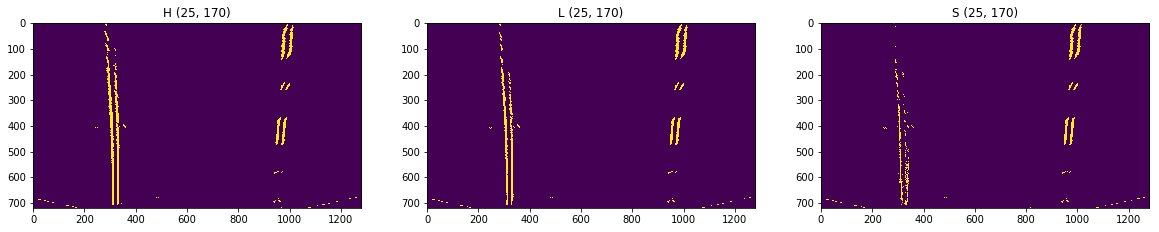

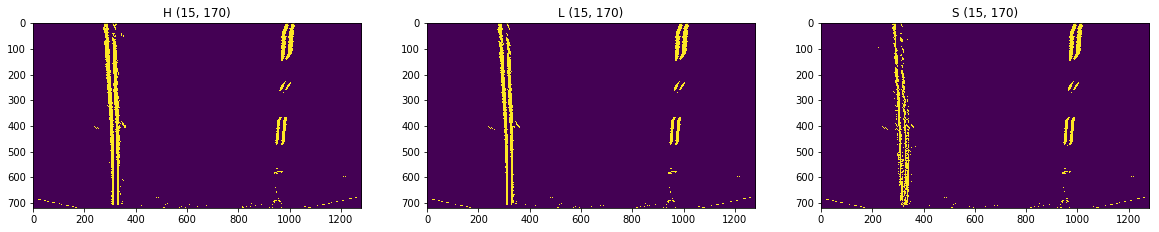

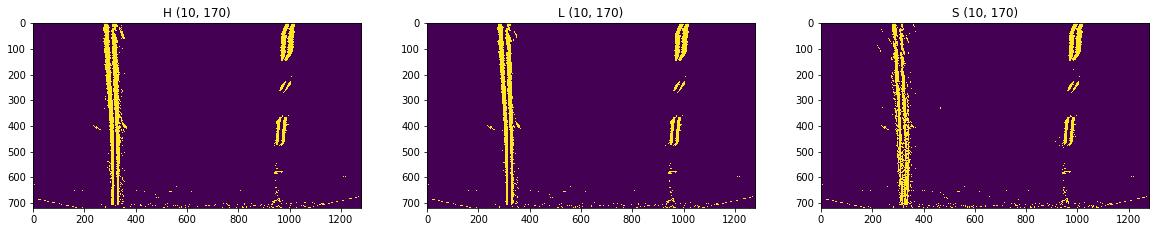

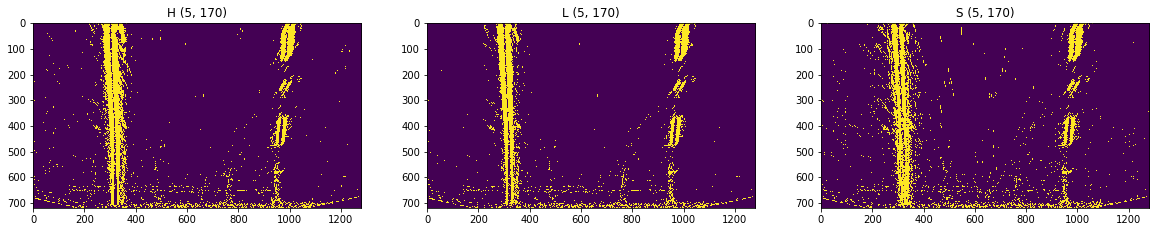

Testing HLS White and Yellow Mask...


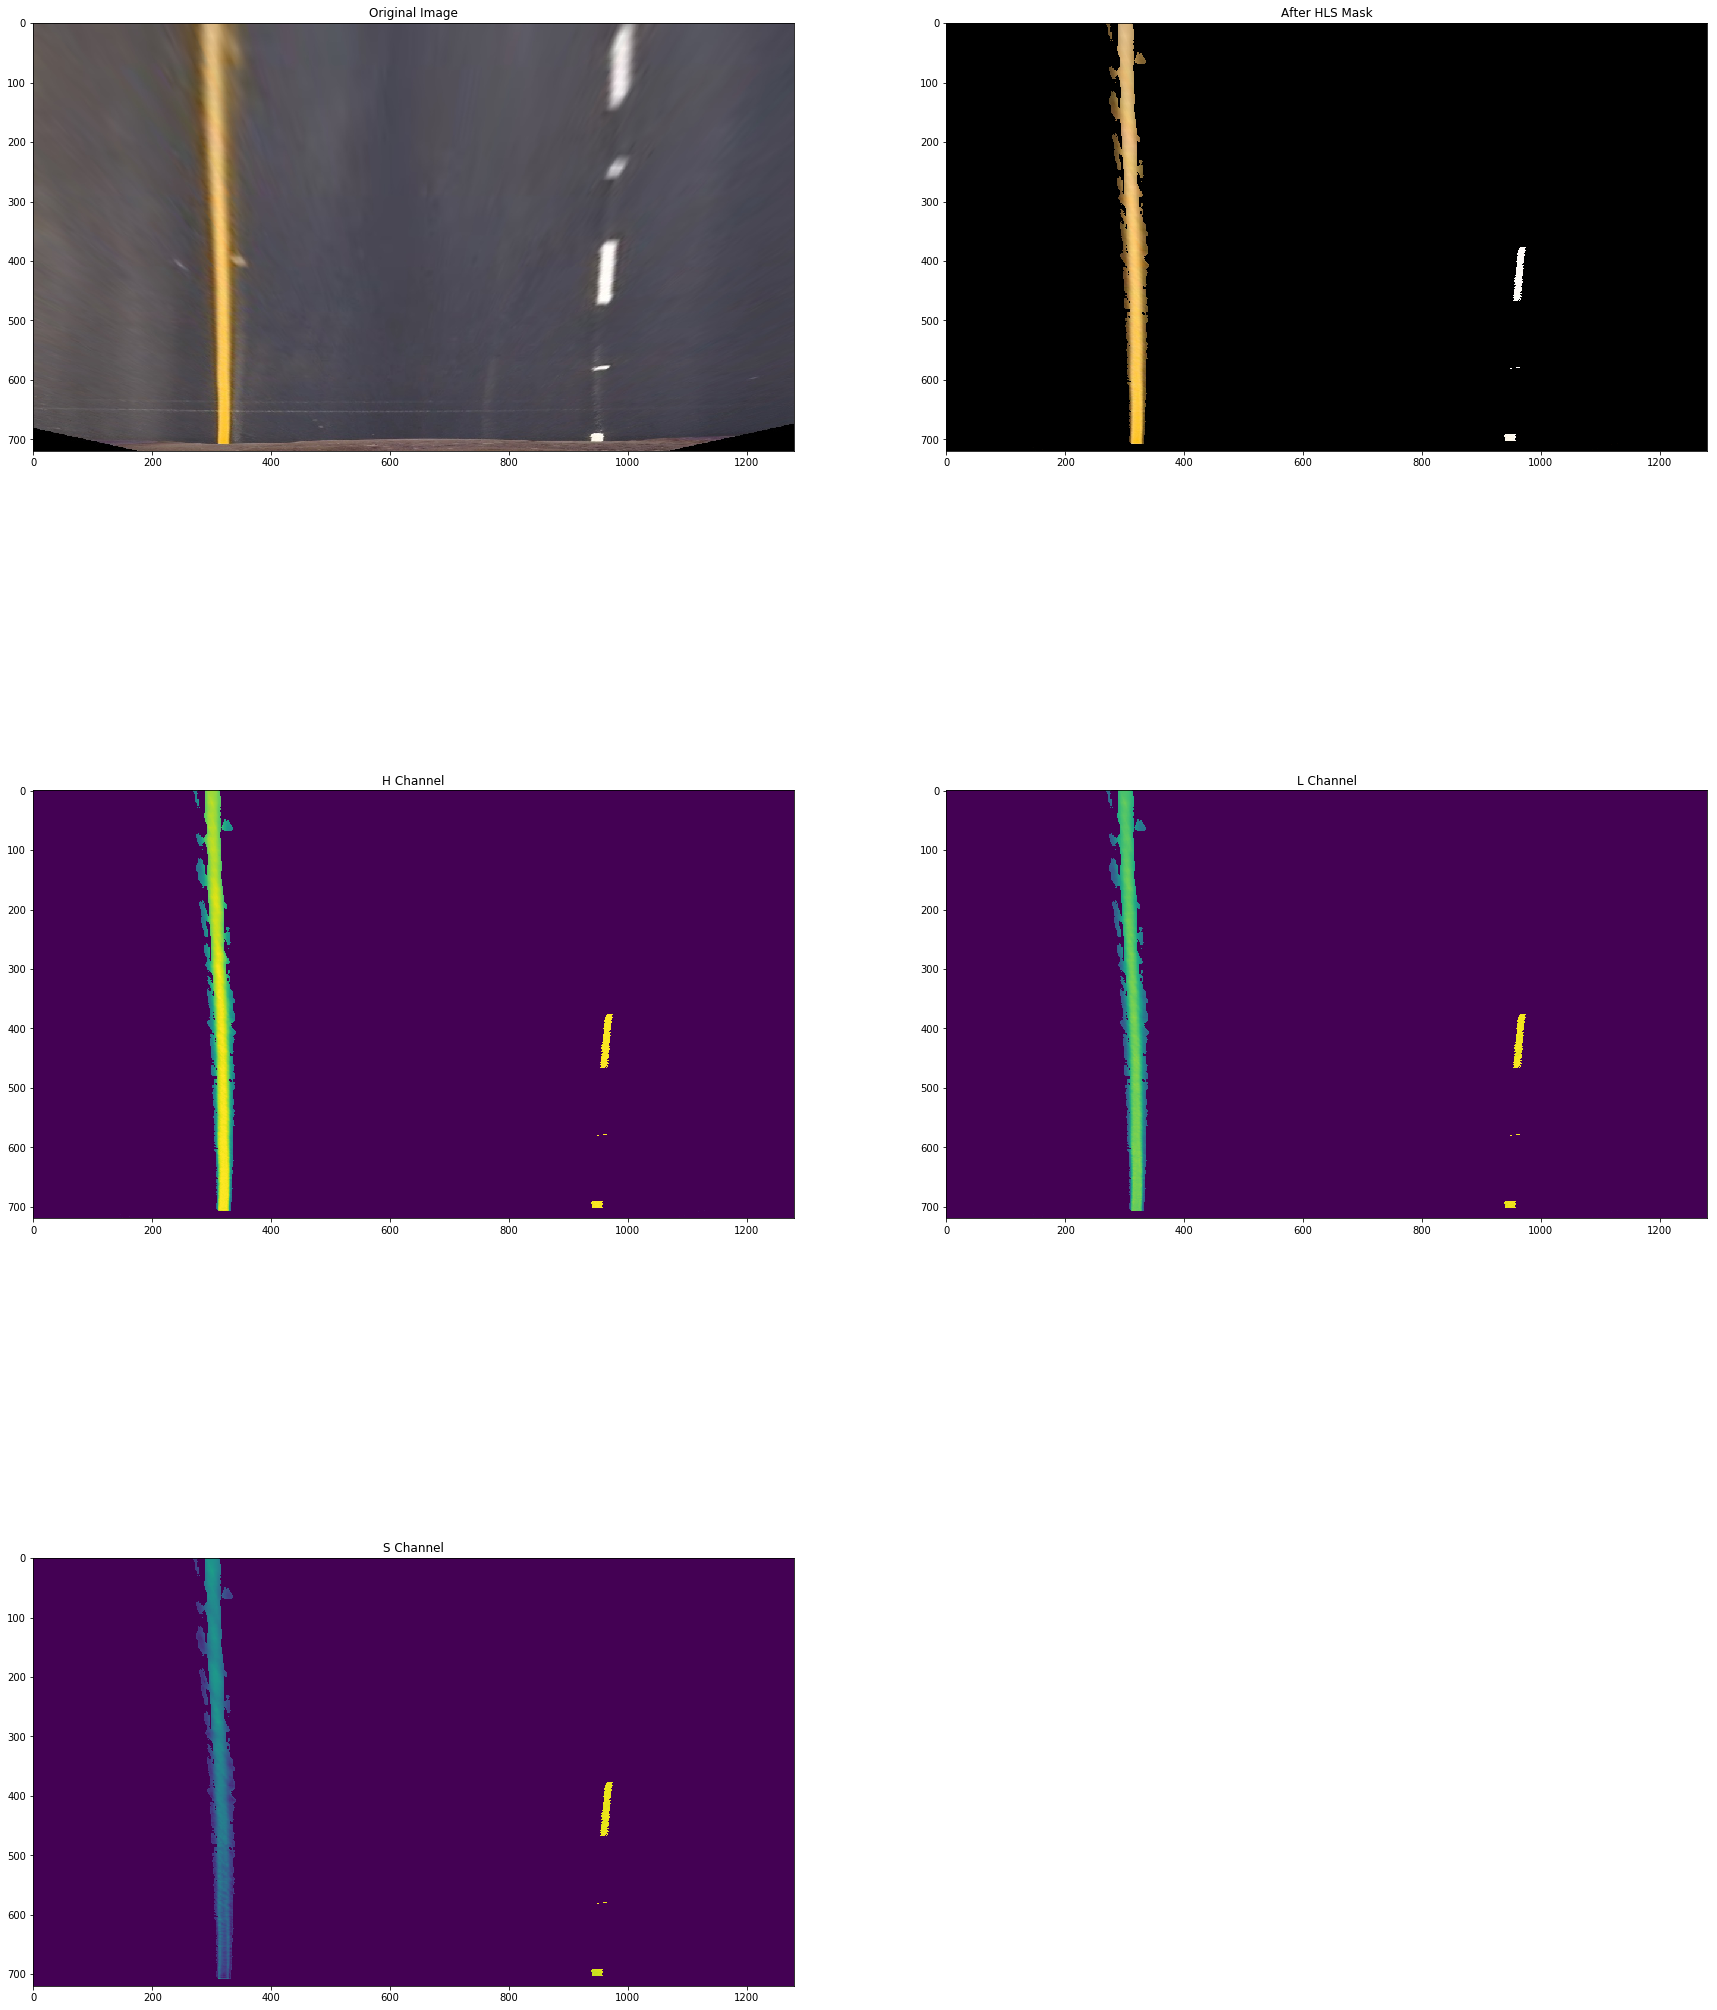

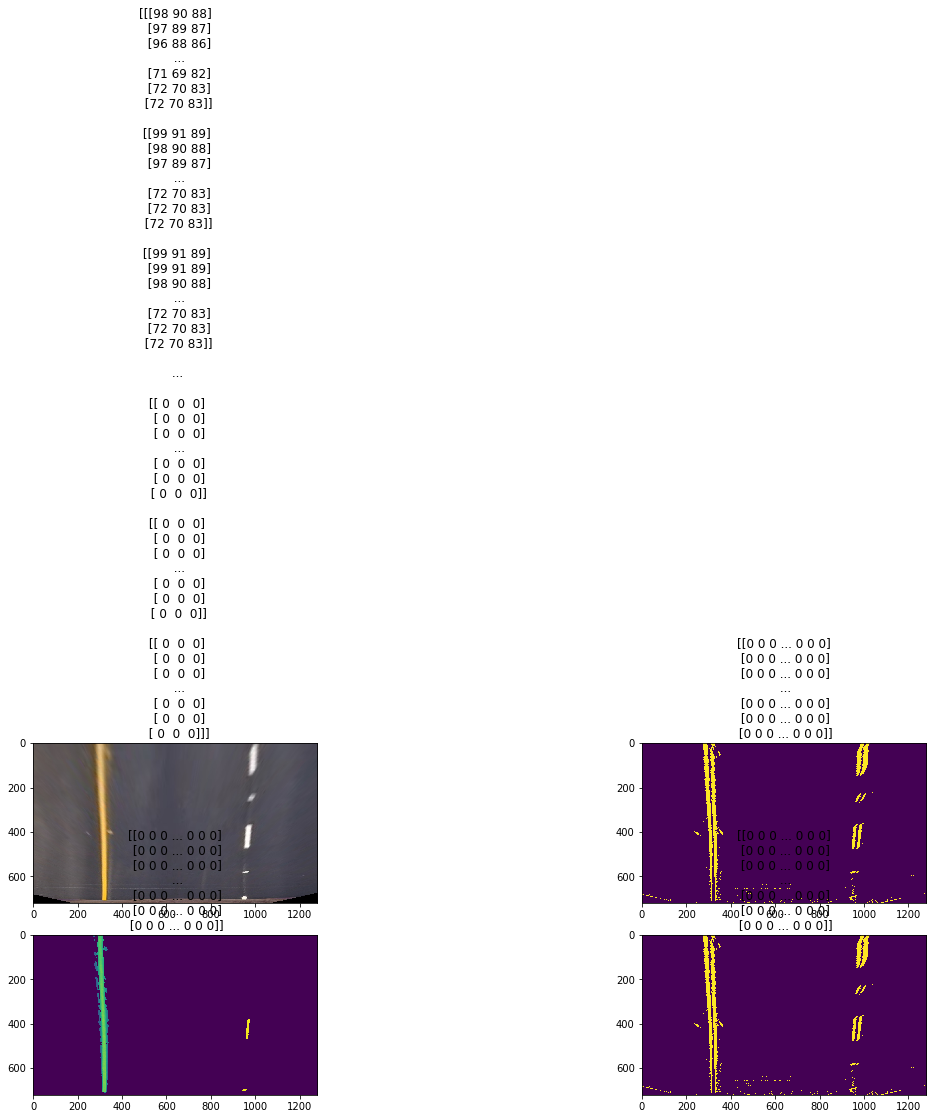

In [36]:
# Make the accentuateLaneLines function available
%run AccentuateLaneLines.ipynb

## Applying and Reversing Bird's Eye View Perspective Transform

In [38]:
def getBirdsEyeSrcDstPoints():
    # taken from the provided writeup_template
    src = np.float32(
        [[585, 460 ],
         [203, 720 ],
         [1127, 720],
         [695, 460 ]])
    
    dst = np.float32(
        [[320, 0  ],
         [320, 720],
         [960, 720],
         [960, 0  ]])
    
    return src, dst

def applyPerspectiveTransform(img, src, dst):
    height, width, channels = img.shape
    
    M = cv2.getPerspectiveTransform(src, dst)

    # apply warp perspective with the matrix responsible for a linear transformation from src to dst (or dst to src if reversed)
    return cv2.warpPerspective(img, M, (width, height), flags=cv2.INTER_LINEAR) 


def birdsEyeView(img):
    # get the source and destination points necessary
    # for warping to a birds eye view
    src, dst = getBirdsEyeSrcDstPoints()
    return applyPerspectiveTransform(img, src, dst)


def birdsEyeViewReverse(img):
    # get the source and destination points necessary
    # for warping to a birds eye view
    src, dst = getBirdsEyeSrcDstPoints()
    return applyPerspectiveTransform(img, dst, src)

## Identifying Lane Lines from a Bird's Eye View Image

In [41]:
def findLanePixels(img, drawSearchWindow=False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img, img, img))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        if drawSearchWindow:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(img, drawSearchWindow=False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(img, drawSearchWindow)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Draw in polynomials of left and right lines
    leftLinePoints  = np.array([[xPt, yPt] for xPt, yPt in zip(left_fitx,  ploty)], np.int32)
    out_img = cv2.polylines(out_img, [leftLinePoints], True, (255, 0, 0), 3)

    rightLinePoints = np.array([[xPt, yPt] for xPt, yPt in zip(right_fitx, ploty)], np.int32)
    out_img = cv2.polylines(out_img, [rightLinePoints], True, (0, 0, 255), 3)
    
    return out_img

def identifyLaneLines(img, drawSearchWindow=False):
    # TODO: run function to detect
    # TODO: run function to use previous
    # TODO: move this functions and it's dependent functions
    # to a separate notebook
    binaryPerspectiveImage = fit_polynomial(img, drawSearchWindow)
    
    # TODO: getRadiusOfCurvature function
    radiusOfCurvature = img
    
    return binaryPerspectiveImage, radiusOfCurvature

## Testing Identifying Lane Lines from B.E.V. Image

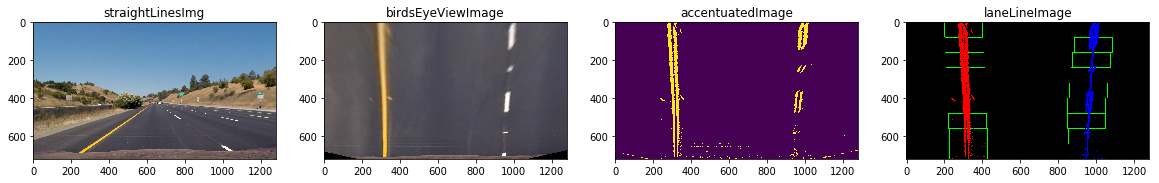

In [42]:
straightLinesImg = mpimg.imread("test_images/straight_lines1.jpg")
birdsEyeViewImage = birdsEyeView(straightLinesImg)
#mpimg.imsave("test_images/straight_lines1_bev.jpg", birdsEyeViewImage)
accentuatedImage  = accentuateLaneLines(birdsEyeViewImage)

laneLineImage, rad = identifyLaneLines(accentuatedImage, True)

plotImages([straightLinesImg, birdsEyeViewImage, accentuatedImage, laneLineImage], 
           ["straightLinesImg", "birdsEyeViewImage", "accentuatedImage", "laneLineImage"], 4)

## Adding Detected Lines Overlay to Original Image

In [43]:
def overlayDetectedLines(img, binaryDetectedLines):
    return cv2.addWeighted(img, 1, binaryDetectedLines, 1, 0)

## Running the Lane Line Detection Pipeline

In [44]:
def pipeline(img, debug=False):
    # We must calibarate our camera with the provided chessboard images
    # (initializes on first call, uses globals on successive calls)
    if debug:
        print("Calibrating Camera...")
    camCalMatrix, camCalDistortionCoeff = calibrateCamera()
    
    # Apply distortion correction to the image with the computed
    # camera calibration matrix and distortion coefficients
    if debug:
        print("Correcting Distortion...")
    distortionCorrectedImage = distortionCorrection(img, camCalMatrix, camCalDistortionCoeff)
    
    # Apply a perspective transform (birds-eye view) to the distortion corrected image
    if debug:
        print("Warping to Birds Eye View...")
    birdsEyeViewImage = birdsEyeView(distortionCorrectedImage)
    
    # Accentuate possible lane lines via color transform, gradients, and color highlighting (white and yellow)
    if debug:
        print("Accentuating Lane Lines...")
    binaryBirdsEyeViewImage = accentuateLaneLines(birdsEyeViewImage)
    
    # TODO: Gradients not implemented
    
    # Identify left and right lane lines on the perspective transformed binary image
    if debug:
        print("Identifying Lane Lines...")
    binaryLinesBirdsEyeViewImage, radiusOfCurvature = identifyLaneLines(binaryBirdsEyeViewImage)
    
    # TODO: positionFromLaneCenter
    
    # Transform the birds eye view image back to the original perspective
    if debug:
        print("Reversing Birds Eye View...")
    binaryLinesImage = birdsEyeViewReverse(binaryLinesBirdsEyeViewImage)
    
    # Overlay the original image with the detected lane lines binary image
    if debug:
        print("Overlaying Detected Lines...")
    detectedLinesOverlayImage = overlayDetectedLines(img, binaryLinesImage)
    
    if debug:
        plotImages([img, 
                    distortionCorrectedImage, 
                    birdsEyeViewImage, 
                    binaryBirdsEyeViewImage, 
                    binaryLinesBirdsEyeViewImage,
                    binaryLinesImage,
                    detectedLinesOverlayImage],
                  ["img", 
                    "distortionCorrectedImage", 
                    "birdsEyeViewImage", 
                    "binaryBirdsEyeViewImage", 
                    "binaryLinesBirdsEyeViewImage",
                    "binaryLinesImage",
                    "detectedLinesOverlayImage"],  
                  columns=3, figsize=(30,25))
    
    return detectedLinesOverlayImage

## Testing the Lane Line Detection Pipeline

Calibrating Camera...
Correcting Distortion...
Warping to Birds Eye View...
Accentuating Lane Lines...
Identifying Lane Lines...
Reversing Birds Eye View...
Overlaying Detected Lines...


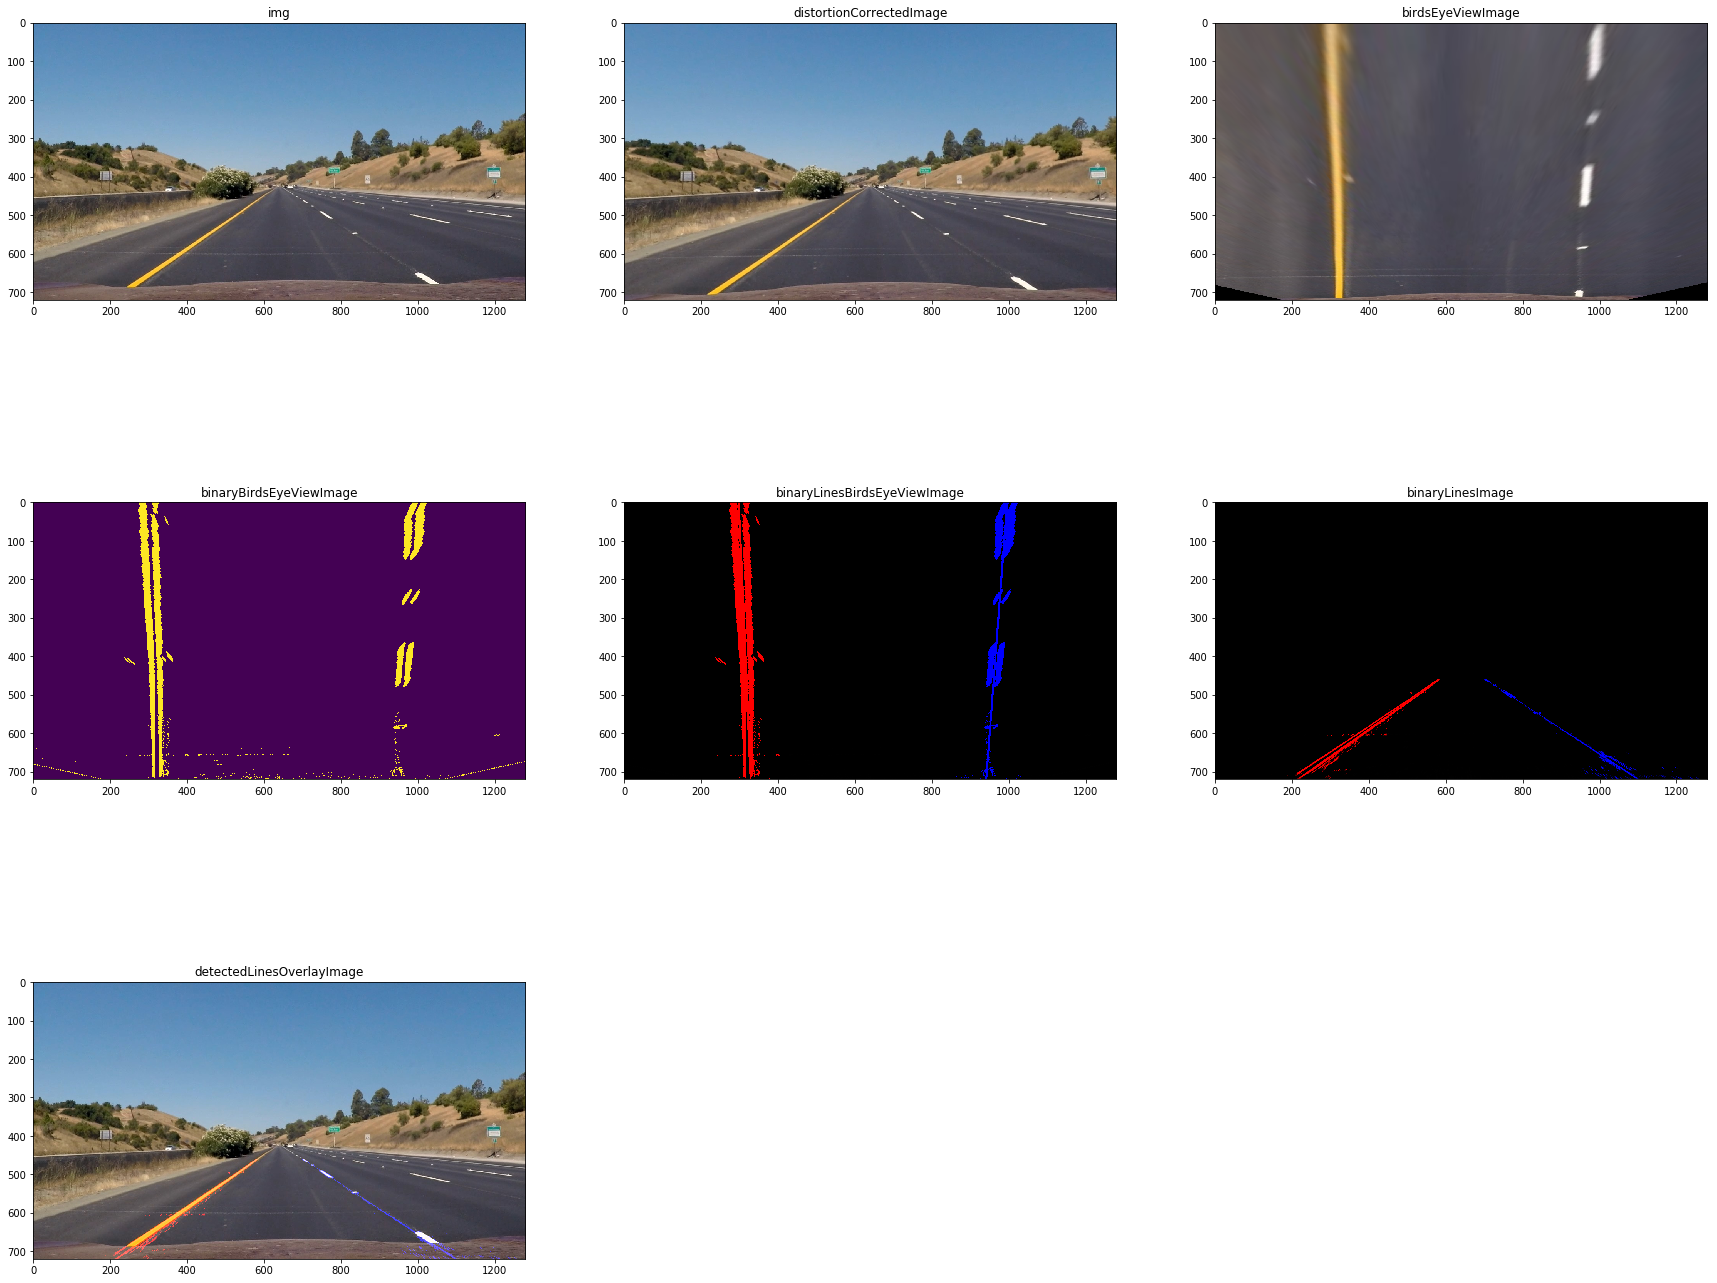

In [45]:
result = pipeline(mpimg.imread("test_images/straight_lines1.jpg"), True)

## Applying Pipeline To a Video

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import display, HTML

def pipelineVideo(inputPath, outputPath, subclip=False): 
    videoClip = None
    
    # apply subclip if subclip flag is set
    if subclip:
        videoClip = VideoFileClip(inputPath).subclip(0,5)
    else:
        videoClip = VideoFileClip(inputPath)
    
    # apply pipeline to video
    processedClip = videoClip.fl_image(pipeline)
    
    # close our clip
    videoClip.reader.close()
    videoClip.audio.reader.close_proc()
    
    # write clip to the specified output path
    %time processedClip.write_videofile(outputPath, audio=False)

## Pipelining and Displaying Video

In [23]:
def pipelineAndDisplayVideo(inputPath, outputPath, subclip=False):
    pipelineVideo(inputPath, outputPath, subclip)
    
    display(HTML("""
    <video width="100%" height="100%" controls>
      <source src="{0}">
    </video>
    """.format(outputPath)))

## Running Pipeline on Project Video

In [25]:
pipelineAndDisplayVideo("project_video.mp4", "output_videos/project_video_output.mp4", True)

OSError: [WinError 6] The handle is invalid

## Running Pipeline on Challenge Video

In [ ]:
pipelineVideo("challenge_video.mp4", "output_videos/challenge_video_output.mp4", True)

## Running Pipeline on Harder Challenge Video

In [15]:
pipelineVideo("harder_challenge_video.mp4", "output_videos/harder_challenge_video_output.mp4", True)

[MoviePy] >>>> Building video output_videos/harder_challenge_video_output.mp4
[MoviePy] Writing video output_videos/harder_challenge_video_output.mp4


 99%|█████████▉| 125/126 [01:08<00:00,  1.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video_output.mp4 

Wall time: 1min 16s
